In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score , roc_curve

In [5]:
pip install plot-metric
from plot_metric.functions import BinaryClassification

In [6]:
def read_data():
    path_train_covid = glob.glob('/content/drive/MyDrive/Deep ConvNet/HW4/COVID,Non COVID-CT Images/train/COVID/*.png')
    path_train_non_covid = glob.glob('/content/drive/MyDrive/Deep ConvNet/HW4/COVID,Non COVID-CT Images/train/Non-COVID/*.png')
    path_test_covid = glob.glob('/content/drive/MyDrive/Deep ConvNet/HW4/COVID,Non COVID-CT Images/test/COVID/*.png')
    path_test_nono_covid = glob.glob('/content/drive/MyDrive/Deep ConvNet/HW4/COVID,Non COVID-CT Images/test/Non-COVID/*.png')
    # print(path_train_covid)
    train_covid = []
    train_non_covid = []
    test_covid = []
    test_non_covid = []

    label_train = []
    label_test = []

    size = 100

    for i in range(len(path_train_covid)):
        img = cv2.imread(path_train_covid[i])
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        
        train_covid.append(resized)
        label_train.append(1)
    train_covid = np.array(train_covid)

    for i in range(len(path_train_non_covid)):
        img = cv2.imread(path_train_non_covid[i])
        resized = cv2.resize(img, ( size, size), interpolation=cv2.INTER_AREA)
        train_non_covid.append(resized)
        label_train.append(0)
    train_non_covid = np.array(train_non_covid)

    train = np.concatenate((train_covid,train_non_covid),axis=0)

    label_train = np.array(label_train)

    x_train = train/255.0
    y_train = one_hot(label_train,2)
    

    for i in range(len(path_test_covid)):
        img = cv2.imread(path_test_covid[i])
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        test_covid.append(resized)
        label_test.append(1)
    test_covid = np.array(test_covid)


    for i in range(len(path_test_nono_covid)):
        img = cv2.imread(path_test_nono_covid[i])
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        test_non_covid.append(resized)
        label_test.append(0)
    test_non_covid = np.array(test_non_covid)

    test = np.concatenate((test_covid, test_non_covid), axis=0)
    label_test = np.array(label_test)

    x_test = test/255.0
    y_test = one_hot(label_test,2)

    np.save('x_train.npy', x_train)
    np.save('x_test.npy', x_test)
    np.save('y_train.npy', label_train)
    np.save('y_test.npy', label_test)

    return x_train , x_test , y_train , y_test , label_train , label_test

x_train , x_test , y_train , y_test , label_train , label_test = read_data()

In [3]:
x_train = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/x_train.npy')
x_test = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/x_test.npy')
y_train = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/y_test.npy')

def one_hot( y, c):
    Ty = np.zeros((max(y.shape), c),dtype=int)
    for i in range(c):
        Ty[y.reshape(max(y.shape)) == i, i] = 1
    return Ty
label_train = y_train
label_test = y_test
y_train = one_hot(y_train,2)
y_test = one_hot(y_test,2)

print(x_train.shape)

(1999, 100, 100, 3)


In [20]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(100,100,3))

x = vgg_model.layers[-1].output

x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(10,activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2,activation='softmax')(x)

model = tf.keras.models.Model(vgg_model.input,output)
model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=50,batch_size=64)
                    
# resualt = model.evaluate(x_test,y_test)[1]

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

accuracy = accuracy_score(label_test,pred)
print('Accuracy:',accuracy)

precision = precision_score(label_test,pred,average='binary')
print('Precision:',precision)

recall = recall_score(label_test,pred,average='binary')
print('Recall:',recall)

f_score = f1_score(label_test,pred,average='binary')
print('F-Measure:',f_score)

auc = roc_auc_score(label_test, pred)
print('AUC:',auc)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

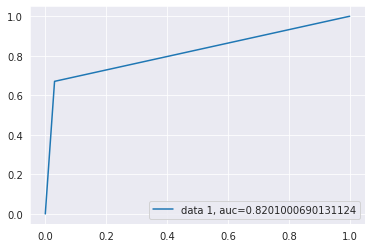

In [13]:
fpr, tpr, _ = roc_curve(label_test,  pred)
auc = roc_auc_score(label_test, pred)
plt.plot(fpr,tpr,label="ROC curve, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

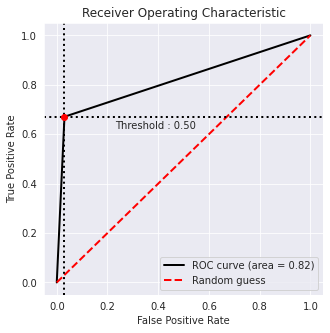

In [14]:
bc = BinaryClassification(label_test, pred, labels=["Covid", "None-covid"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()